In [1]:
#barrnap run on raapoi in quicktest partition as:
#nowakvi@c03n01:/nfs/scratch/nowakvi$ barrnap --quiet --threads 8 --kingdom bac --outseq ./barrnap_6_sponges/Zamp_150_Nano_16S.fasta ./Zamp_150_Tru_adap_plus_Nano_meta_SPAdes/contigs.fasta
#default is --kingdom bac, so outputs the same as previously
#need to filter eukaryote reads after identification with SILVA

In [2]:
from Bio import SeqIO
import pandas as pd
import seaborn as sns

In [3]:
def LengthChecker(in_file,out_file,cutoff_length=800,prefix="16S",
                  in_file_format = "fasta",out_file_format = "fasta"):
    """
    Check a multi fasta (in_file) for length cut off and presence of a prefix 
    Writes items that pass to a new file (out_file)
    Format of both in and out files must be specified
    use cutoff 1400 for 16s
    use cutoff 2800 for 23s
    """
    
    to_write = []
    for record in SeqIO.parse(in_file,in_file_format):
        #print(len(record), record.name.startswith(prefix))
        if len(record) > cutoff_length and record.name.startswith(prefix):
            to_write.append(record)
    with open(out_file,"w") as F:
        SeqIO.write(to_write,F,out_file_format)

In [4]:
#base_dir = "put the path to the directory where you have all of the data files here"
base_dir = "/Users/vincentn/Documents/Sequencing/BinQuant_VN/"
#set the path to your CD-hit clusters output file
cdhit_file = base_dir + "16s_partial/cdhit_99_w_euros_partials.txt"

In [5]:
def ParseCDHitClusters_Cov(cluster_file):
    """
    Parses the cluster file from CD-Hit and returns a list of lists, where each entry contains
    all members of a cluster
    """
    clusters = []
    entry = None
    with open(cluster_file, 'r') as F:
        
        for line in F:
            #print(line)
            if line.startswith(">"):
                if entry:
                    clusters.append(entry.copy())

                entry = []
            else:
                
                entry.append(line.split()[2][:-3])
        return clusters

In [6]:
#Parse cdhit file to list of lists
vn_16s_cluster_list = ParseCDHitClusters_Cov(cdhit_file)
#print(vn_16s_cluster_list[1])
#enumerate function counts occurence of items in a list 
#As clusters shouldn't occur more than once it creates number keys for all clusters 
vn_16s_cluster_dict = {i[0]:i[1] for i in enumerate(vn_16s_cluster_list)}
#print(vn_16s_cluster_dict.keys())
#print(len(vn_16s_cluster_dict))

In [7]:
#covstat file if you don't have coverage info in your fasta headers
#in this case used for the hybrind assembly data
cov_df = pd.read_csv(base_dir + "covstat/PAT/MH-Pat_L2.reads_mapped-to_MH_pat_all.assembly.fa.covstat",
                     sep = "\t",index_col=0)

In [8]:
def ParseHeader(header,cov_df = cov_df):
    """
    Parses a fasta header and returns a tuple of (sample_name,coverage)
    note, this only works if your fasta headers are in the same format,
    you'll need to check that it works for your fasta headers (it proably won't)
    all the splitting and startswith stuff is specific to the data I was working with
    """
    items = header.split("_")
    #print(items)
    name = items[-1]
    #print(items[1])
    #change the .startswith(bit) to match the things for which you need to look up cov data seperately
    if items[1].startswith("rRNA::scf"):
        #print("MH!!")
        contig = items[1].split(":")[2]
        #print(contig)
        cov = cov_df.loc[contig,"Avg_fold"]
    # elif clause, for things where there is no cov data, default to 1
    # agin you will need to change this to suit your fasta headers
    elif items[1].startswith("rRNA::LXN") or items[1].startswith("rRNA::MKW"):
        cov = 1
    else:
        cov = float(items[-2].split(":")[0])
    print(name,cov)
    return (name,cov)

In [9]:
#make an empty data frame with appropriate row and column names
vn_df = pd.DataFrame(index = range(len(vn_16s_cluster_dict)),
                     columns=["zamp","CS200","CS202","CS203","CS204","CS211","s0","s1","s2","s3","sf","pf","aa"])
#intially it's filled with NaN, so make it all zeros
vn_df[:] = 0.0
#currently it's a dataframe of objects, make it into floats, or else you'll have a bad time later...
vn_df = vn_df.astype("float")

In [10]:
#parse all of the things in the cluster list, and add the update the dataframe you made earlier
for i in enumerate(vn_16s_cluster_list):
    #print(i)
    index = i[0]
    for j in i[1]:
        tup = ParseHeader(j)
        #print(tup)
        sample = tup[0]
        cov = tup[1]
        #if any duplicates exist, only count the first one
        if vn_df.loc[index,sample] == 0:
            vn_df.loc[index,sample] += cov

s0 79.8457
s0 587.1489
s0 587.1489
s0 222.8097
s0 222.8097
s0 111.7652
s0 111.7652
s0 111.7652
s0 79.8457
s0 39.8441
s0 39.8441
s0 64.7518
s0 51.9189
s0 1489.1185
s0 39.8441
s0 62.4865
s0 62.4865
s0 39.8441
s0 111.7652
s1 3.054137
s2 3.575898
CS200 13.171807
CS202 4.124048
CS203 13.88215
CS204 13.921772
CS211 34.365486
zamp 3.914828
aa 1
pf 1
sf 1
CS200 17.54159
CS202 11.198275
CS203 8.622643
CS204 3.624132
CS211 2.801003
zamp 4.308384
aa 1
pf 1
s0 89.2624
s0 538.8654
s0 538.8654
s0 538.8654
s0 538.8654
s1 85.856726
s2 38.081437
s3 261.925299
CS200 17.656619
CS203 7.392854
CS204 4.565654
CS211 5.73978
zamp 3.081921
aa 1
pf 1
CS200 13.849843
CS203 8.596111
CS204 3.811529
CS211 5.370115
zamp 1.763494
aa 1
pf 1
CS200 9.728265
CS202 5.190539
CS203 8.695858
CS204 6.80688
CS211 5.96938
aa 1
pf 1
CS200 9.039248
CS202 4.123483
CS203 5.884533
CS204 5.79248
CS211 5.155601
zamp 1.446532
pf 1
CS200 5.319572
CS204 6.047066
CS211 3.984766
zamp 1.088102
pf 1
sf 1
CS200 3.169091
CS202 1.9546
CS203 2.5

In [11]:
#set the things with really low coverage to zero
vn_df[vn_df < 0.1] = 0

In [12]:
print(len(vn_df))
vn_df.head(10)

357


,zamp,CS200,CS202,CS203,CS204,CS211,s0,s1,s2,s3,sf,pf,aa
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,79.8457,3.054137,3.575898,0.000000,0.0,0.0,0.0
1,3.914828,13.171807,4.124048,13.882150,13.921772,34.365486,0.0000,0.000000,0.000000,0.000000,1.0,1.0,1.0
2,4.308384,17.541590,11.198275,8.622643,3.624132,2.801003,0.0000,0.000000,0.000000,0.000000,0.0,1.0,1.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,89.2624,85.856726,38.081437,261.925299,0.0,0.0,0.0
4,3.081921,17.656619,0.000000,7.392854,4.565654,5.739780,0.0000,0.000000,0.000000,0.000000,0.0,1.0,1.0
5,1.763494,13.849843,0.000000,8.596111,3.811529,5.370115,0.0000,0.000000,0.000000,0.000000,0.0,1.0,1.0
6,0.000000,9.728265,5.190539,8.695858,6.806880,5.969380,0.0000,0.000000,0.000000,0.000000,0.0,1.0,1.0
7,1.446532,9.039248,4.123483,5.884533,5.792480,5.155601,0.0000,0.000000,0.000000,0.000000,0.0,1.0,0.0
8,1.088102,5.319572,0.000000,0.000000,6.047066,3.984766,0.0000,0.000000,0.000000,0.000000,1.0,1.0,0.0
9,0.000000,3.169091,1.954600,2.537836,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.0,1.0,1.0


In [13]:
#reading in SILVA output containing the taxonomy of sequences >800bp (n=358)
phylo_file = base_dir + "all_w_partials_gt_800.csv"
phylo_df = pd.read_csv(phylo_file,sep = ";")

In [14]:
#get the names of the sponge samples, assign these to the full_name column
#assumes the contig names end with _samplename
sample_names = [i.split("_")[-1] for i in phylo_df["sequence_identifier"]]
phylo_df["full_name"] = sample_names

#Pull the contig name out from the crazy string and replace the sequence_identifier column with these
contigs_names = [i.split("&a")[2] for i in phylo_df["sequence_identifier"]]
phylo_df["sequence_identifier"] = contigs_names

In [15]:
phylo_df.head()

,job_id,sequence_number,sequence_identifier,full_name,sequence_score,bp_score,cutoff_head,cutoff_tail,identity,quality,...,stoppos,ecolipos,bps,gene_bps,turn,lca_tax_embl,lca_tax_greengenes,lca_tax_ltp,lca_tax_rdp,lca_tax_slv
0,629813,1,scf7180000017418.513682,s0,0.945472,118,4,13,89.6114,94,...,43282,3,1542,1541,none,Bacteria;environmental samples;,k__Bacteria;p__Acidobacteria;c__AT-s2-57;,Unclassified;,Bacteria;,Bacteria;Acidobacteria;Subgroup 26;
1,629813,2,scf7180000020227.146740,s0,0.989686,120,4,12,94.2269,98,...,43281,3,1541,1541,none,Bacteria;environmental samples;,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Unclassified;,"Bacteria;""Proteobacteria"";Gammaproteobacteria;",Bacteria;Proteobacteria;Gammaproteobacteria;UB...
2,629813,3,scf7180000017258.4699109,s0,0.986355,122,3,13,94.5406,98,...,43282,4,1537,1536,none,Bacteria;environmental samples;,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Unclassified;,"Bacteria;""Proteobacteria"";Gammaproteobacteria;...",Bacteria;Proteobacteria;Gammaproteobacteria;Ni...
3,629813,4,scf7180000017255.2650019,s0,0.968332,121,3,13,91.3506,96,...,43282,4,1535,1534,none,Bacteria;,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Unclassified;,"Bacteria;""Proteobacteria"";Gammaproteobacteria;...",Bacteria;Proteobacteria;Gammaproteobacteria;
4,629813,5,scf7180000017259.2670330,s0,0.985755,120,4,12,94.2269,98,...,43281,3,1541,1541,none,Bacteria;environmental samples;,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Unclassified;,"Bacteria;""Proteobacteria"";Gammaproteobacteria;",Bacteria;Proteobacteria;Gammaproteobacteria;UB...


In [16]:
#split the silva tax into useful bits and make thes into a list of lists
to_table = [i.split(";") for i in phylo_df["lca_tax_slv"]]

#make the above list into a dataframe
taxa = pd.DataFrame(to_table)

#rename the rows with contig names (contig on which 16s sequence was found)
taxa.index = list(phylo_df["sequence_identifier"])

#add a row with the sample names (sponge of origin)
taxa["sample_name"] = list(phylo_df["full_name"])

#CHANGED VERSION ONLY KEEPS THOSE THAT ARE CLASSIFIED AS BACTERIA
taxa = taxa[taxa[0] == 'Bacteria']

In [17]:
print(len(taxa))
taxa.head()

337


,0,1,2,3,4,5,6,7,8,9,10,sample_name
scf7180000017418.513682,Bacteria,Acidobacteria,Subgroup 26,,None,None,None,None,None,None,None,s0
scf7180000020227.146740,Bacteria,Proteobacteria,Gammaproteobacteria,UBA10353 marine group,,None,None,None,None,None,None,s0
scf7180000017258.4699109,Bacteria,Proteobacteria,Gammaproteobacteria,Nitrosococcales,Nitrosococcaceae,,None,None,None,None,None,s0
scf7180000017255.2650019,Bacteria,Proteobacteria,Gammaproteobacteria,,None,None,None,None,None,None,None,s0
scf7180000017259.2670330,Bacteria,Proteobacteria,Gammaproteobacteria,UBA10353 marine group,,None,None,None,None,None,None,s0


In [18]:
#make a dictionay mapping bacterial contigs to cluster row numbers in the abundance dataframe
rev_contig_map = {}
for tup in enumerate(vn_16s_cluster_list):
    for seq in tup[1]:
        #print(seq)
        if seq.split(":")[2] in taxa["sample_name"]:    
            name = seq.split(":")[2]
        #print(name)
            rev_contig_map[name] = tup[0]
print(len(rev_contig_map.keys()))
#example: 'scf7180000024124.52845': 0

336


In [19]:
#make an empty data frame with appropriate row and column names
vn_df_bac_only = pd.DataFrame(index = range(len(vn_16s_cluster_dict)),
                     columns=["zamp","CS200","CS202","CS203","CS204","CS211","s0","s1","s2","s3","sf","pf","aa"])
#intially it's filled with NaN, so make it all zeros
vn_df_bac_only[:] = 0.0
#currently it's a dataframe of objects, make it into floats, or else you'll have a bad time later...
vn_df_bac_only = vn_df_bac_only.astype("float")

In [20]:
#Parse in abundance only if contig is found in rev_contig_map, i.e. is bacterial
for i in rev_contig_map.values():
    #print(i)
    vn_df_bac_only.loc[i] = vn_df.loc[i]
#remove zero rows
vn_df_bac_only = vn_df_bac_only[(vn_df_bac_only.T != 0).any()]

In [21]:
len(vn_df_bac_only)

336

In [22]:
#make a new data frame, subset_with_coverage, which is only the things for which there is coverage data
bac_subset_with_coverage = vn_df_bac_only.loc[:,["zamp","CS200","CS202","CS203","CS204","CS211","s0","s1","s2","s3"]]
print(len(bac_subset_with_coverage))
#remove the zero rows
bac_subset_with_coverage = bac_subset_with_coverage[(bac_subset_with_coverage.T != 0).any()]
print(len(bac_subset_with_coverage))

336
256


In [23]:
#make a new data frame, subset_togan, which is only the tongan sponges
bac_subset_tongan = vn_df_bac_only.loc[:,["zamp","CS200","CS202","CS203","CS204","CS211"]]
print(len(bac_subset_tongan))
#remove the zero rows
bac_subset_tongan = bac_subset_tongan[(bac_subset_tongan.T != 0).any()]
print(len(bac_subset_tongan))

336
212


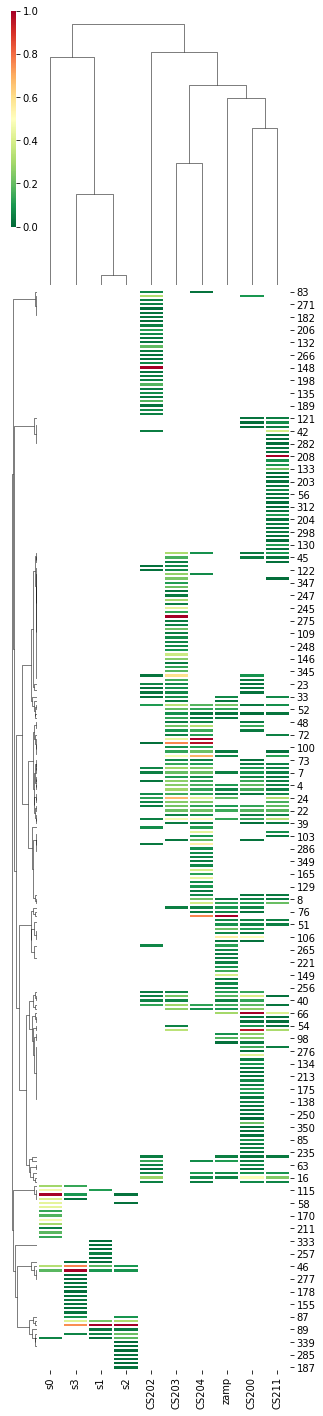

In [24]:
plot_a = sns.clustermap(bac_subset_with_coverage, cmap='RdYlGn_r', linewidths=1,figsize=(5,25),
                   mask=bac_subset_with_coverage==0, method = "average",metric="cosine",standard_scale=1)

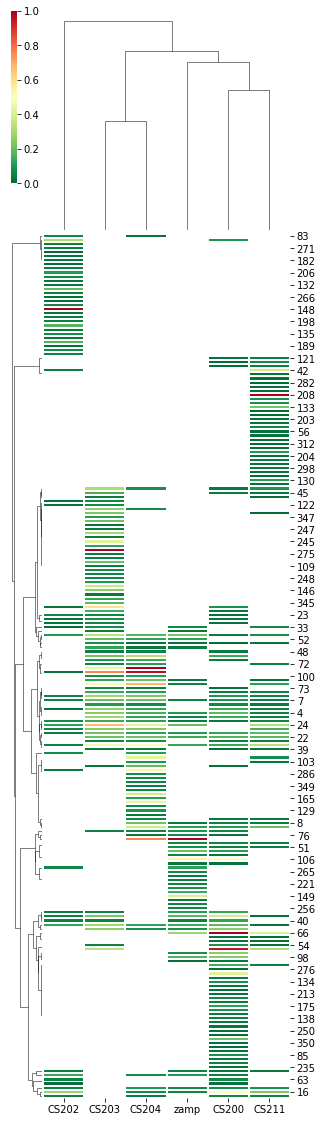

In [25]:
plot_b = sns.clustermap(bac_subset_tongan, cmap='RdYlGn_r', linewidths=1, figsize=(5,20),
                   mask=bac_subset_tongan==0, method = "average",metric="cosine",standard_scale=1)

In [26]:
#make a copy of the dataframe and convert to binary data
vn_bin_df_bac_only = vn_df_bac_only.copy()
vn_bin_df_bac_only[vn_bin_df_bac_only>0] = 1
#use this to drop the all zeros rows if necessary to run cosine similarity
vn_bin_df_bac_only = vn_bin_df_bac_only[(vn_bin_df_bac_only.T != 0).any()]

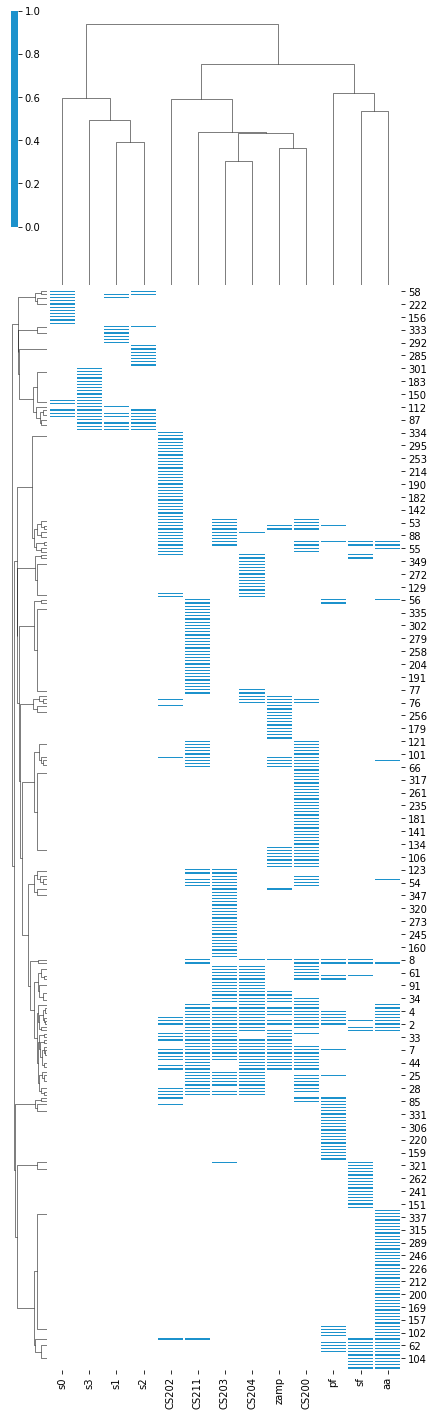

In [27]:
plot_c = sns.clustermap(vn_bin_df_bac_only, cmap=["#1c92cc"], linewidths=1,figsize=(7,25),
                   mask=vn_bin_df_bac_only==0,method = "average",metric="cosine")

In [28]:
#Saves the files to desktop
plot_a.savefig("/Users/vincentn/Documents/Sequencing/BinQuant_VN/16S_wpartials_VN_abundance_plot_bac_only.pdf")
plot_c.savefig("/Users/vincentn/Documents/Sequencing/BinQuant_VN/16S_wpartials_VN_binary_plot_bac_only.pdf")

In [29]:
#Copy the taxa dataframe, so originial is not mutated
taxa_copy = taxa.copy()

#add the Phylum to the Class name
for i in range(len(taxa_copy.loc[:,2])):
    if taxa_copy.iloc[i,2] != None:
        taxa_copy.iloc[i,1] = taxa_copy.iloc[i,1] + "-" + taxa_copy.iloc[i,2]

In [30]:
#creates empty dataframe by class (change column in taxa_copy[] to chnange taxonomy)
class_df = pd.DataFrame(index=list(set(taxa_copy[1])),columns=vn_df.columns)
class_df[:] = 0
class_df = class_df.astype("float")

In [31]:
#adds abundances to class_df
for i in taxa_copy.index:
    if i in rev_contig_map:
        sample = taxa_copy.loc[i,"sample_name"]
        #change the 2 if you want to count at a different level (genus for example)
        bact_class = taxa_copy.loc[i,1]
        abundance = vn_df_bac_only.loc[rev_contig_map[i],sample]
        class_df.loc[bact_class,sample] += abundance

In [32]:
class_df

,zamp,CS200,CS202,CS203,CS204,CS211,s0,s1,s2,s3,sf,pf,aa
Planctomycetes-Planctomycetacia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,34.768087,1.597439,1.956897,0.0,0.0,0.0
Gemmatimonadetes-PAUC43f marine benthic group,0.000000,5.319572,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,1.0,0.0
Chloroflexi-JG30-KF-CM66,0.000000,0.000000,0.000000,1.956294,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,2.0
PAUC34f-,0.000000,72.004622,6.196169,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,1.0
Acidobacteria-Subgroup 9,0.000000,17.656619,6.434082,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0
Acidobacteria-Subgroup 6,2.013501,42.833466,3.790774,46.989768,0.928832,12.003777,0.0000,0.000000,0.000000,0.000000,0.0,0.0,2.0
Proteobacteria-Alphaproteobacteria,1.822632,8.221491,7.636975,0.770588,2.043478,12.430902,208.4934,0.000000,4.362984,9.276956,2.0,0.0,7.0
Kiritimatiellaeota-Kiritimatiellae,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,134.4892,0.910414,0.000000,0.000000,0.0,0.0,0.0
Verrucomicrobia-Verrucomicrobiae,0.000000,2.116062,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0
Nitrospirae-Nitrospira,1.225280,0.000000,0.000000,8.695858,0.000000,0.000000,40.2592,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [34]:
class_df.to_csv('/Users/vincentn/Documents/Sequencing/BinQuant_VN/Class_df_abundance_bac_only.csv')